In [2]:
from s2width import WidthModel
import numpy as np
from tqdm import trange

In [3]:
# Create model with physical constants
Dl = 20.0   # cm^2/s
vd = 0.2    # cm/µs
C = 0.1
dC = 0.01
model = WidthModel(Dl, vd, C=C, dC=dC)
widths=np.linspace(1,4000,200)

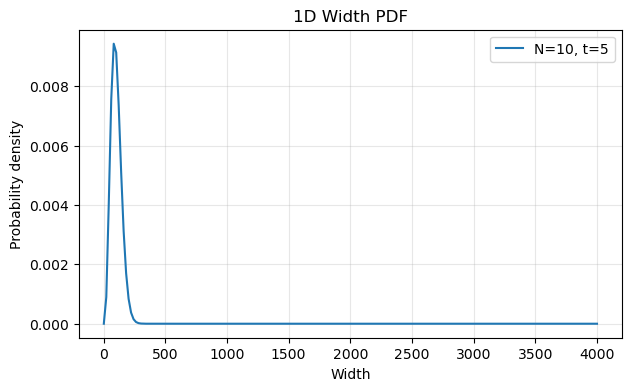

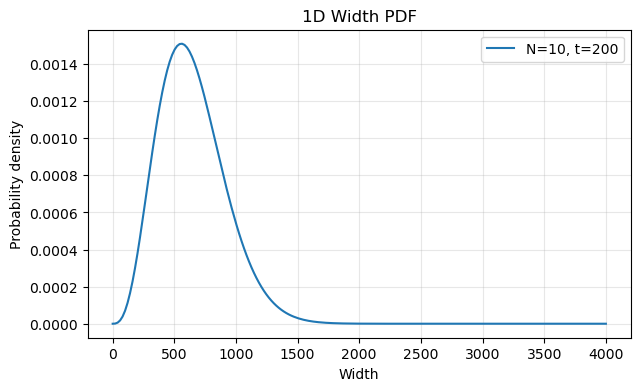

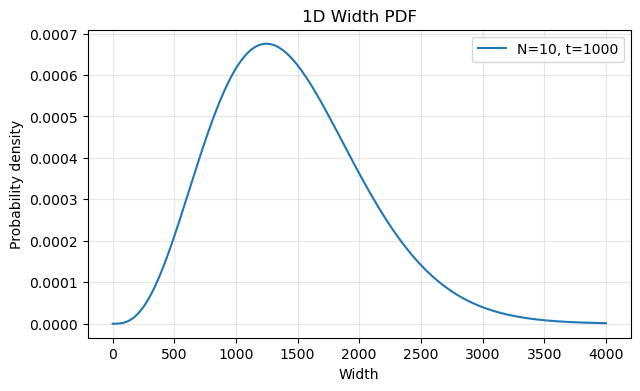

CPU times: user 5.27 s, sys: 6.93 ms, total: 5.28 s
Wall time: 5.3 s


(array([1.00000000e+00, 2.10954774e+01, 4.11909548e+01, 6.12864322e+01,
        8.13819095e+01, 1.01477387e+02, 1.21572864e+02, 1.41668342e+02,
        1.61763819e+02, 1.81859296e+02, 2.01954774e+02, 2.22050251e+02,
        2.42145729e+02, 2.62241206e+02, 2.82336683e+02, 3.02432161e+02,
        3.22527638e+02, 3.42623116e+02, 3.62718593e+02, 3.82814070e+02,
        4.02909548e+02, 4.23005025e+02, 4.43100503e+02, 4.63195980e+02,
        4.83291457e+02, 5.03386935e+02, 5.23482412e+02, 5.43577889e+02,
        5.63673367e+02, 5.83768844e+02, 6.03864322e+02, 6.23959799e+02,
        6.44055276e+02, 6.64150754e+02, 6.84246231e+02, 7.04341709e+02,
        7.24437186e+02, 7.44532663e+02, 7.64628141e+02, 7.84723618e+02,
        8.04819095e+02, 8.24914573e+02, 8.45010050e+02, 8.65105528e+02,
        8.85201005e+02, 9.05296482e+02, 9.25391960e+02, 9.45487437e+02,
        9.65582915e+02, 9.85678392e+02, 1.00577387e+03, 1.02586935e+03,
        1.04596482e+03, 1.06606030e+03, 1.08615578e+03, 1.106251

In [4]:
%%time

# Plot a 1D PDF at drift time=200 µs and N=5 electrons
model.plot_pdf_1d(n=10, drift_time=5, widths=widths)
model.plot_pdf_1d(n=10, drift_time=200, widths=widths)
model.plot_pdf_1d(n=10, drift_time=1000, widths=widths)

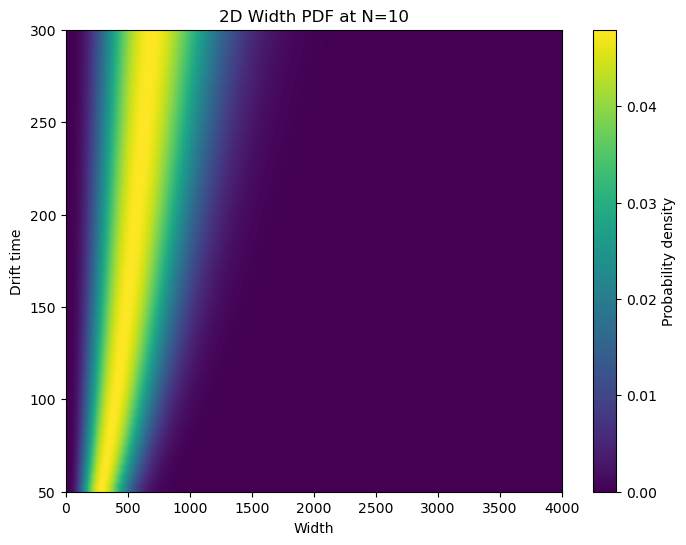

In [4]:
# Plot a 2D PDF slice at fixed N=10 electrons
drift_times = np.linspace(50, 1040, 50)
model.plot_pdf_2d_fixedN(n=10, drift_times=drift_times, widths=widths)

In [48]:
# Define grid
n_values = np.arange(4, 20, 1)
drift_times = np.linspace(50, 1040, 50)
widths = np.linspace(0, 4000, 200)

In [49]:
import time

# Start the timer
start_time = time.time()

# Construct the 3D PDF
pdf_3d = model.build_pdf_3d(n_values, drift_times, widths)

# Stop the timer
end_time = time.time()

print(f"3D PDF construction took {end_time - start_time:.2f} seconds")

print("PDF shape:", pdf_3d.shape)  # (len(n_values), len(drift_times), len(widths))

3D PDF construction took 191.00 seconds
PDF shape: (16, 50, 200)


In [50]:
def compute_percentile_bounds(pdf_3d, widths, lower=0.5, upper=99.5):
    """
    Compute percentile bounds for a 3D PDF.

    Parameters:
    - pdf_3d: array of shape (N, drift_time, width)
    - widths: array of width values
    - lower: lower percentile (0-100)
    - upper: upper percentile (0-100)

    Returns:
    - lower_bounds: array (N, drift_time)
    - upper_bounds: array (N, drift_time)
    """
    N_len, dt_len, w_len = pdf_3d.shape
    lower_bounds = np.zeros((N_len, dt_len))
    upper_bounds = np.zeros((N_len, dt_len))

    for i in range(N_len):
        for j in range(dt_len):
            cdf = np.cumsum(pdf_3d[i, j, :])
            cdf /= cdf[-1]
            lower_bounds[i, j] = np.interp(lower / 100, cdf, widths)
            upper_bounds[i, j] = np.interp(upper / 100, cdf, widths)

    return lower_bounds, upper_bounds


In [51]:
def sample_events(pdf_3d, n_values, drift_times, widths, M,
                  lower_bounds, upper_bounds,
                  n_probs=None, dt_probs=None):
    """
    Monte Carlo sampling of M events through the 3D PDF with arbitrary N and drift_time distributions.

    Parameters:
    - pdf_3d: 3D array (N, drift_time, width)
    - n_values: array of N values
    - drift_times: array of drift times
    - widths: array of width values
    - M: number of events to sample
    - lower_bounds, upper_bounds: 2D arrays (N, drift_time) of percentile bounds
    - n_probs: optional probability distribution for n_values (must sum to 1)
    - dt_probs: optional probability distribution for drift_times (must sum to 1)

    Returns:
    - events: dict with sampled N, drift_time, width, and outside_bounds flag
    """
    N_len, dt_len, w_len = pdf_3d.shape
    events = {
        "N": np.zeros(M, dtype=int),
        "drift_time": np.zeros(M),
        "width": np.zeros(M),
        "outside_bounds": np.zeros(M, dtype=bool)
    }

    # Default to uniform if no probabilities provided
    if n_probs is None:
        n_probs = np.ones(N_len) / N_len
    if dt_probs is None:
        dt_probs = np.ones(dt_len) / dt_len

    for i in range(M):
        # Sample N and drift_time according to given probabilities
        N = np.random.choice(n_values, p=n_probs)
        dt = np.random.choice(drift_times, p=dt_probs)

        n_idx = np.where(n_values == N)[0][0]
        dt_idx = np.where(drift_times == dt)[0][0]

        # Sample width from the PDF slice
        pdf_slice = pdf_3d[n_idx, dt_idx, :]
        pdf_slice_sum = np.sum(pdf_slice)
        if pdf_slice_sum == 0 or np.isnan(pdf_slice_sum):
            pdf_slice = np.ones_like(pdf_slice) / len(pdf_slice)
        else:
            pdf_slice /= pdf_slice_sum

        width = np.random.choice(widths, p=pdf_slice)

        # Randomize drift time between 0 and 1040
        dt_new = np.random.uniform(0, 1040)
        lower = np.interp(dt_new, drift_times, lower_bounds[n_idx, :])
        upper = np.interp(dt_new, drift_times, upper_bounds[n_idx, :])
        outside = width < lower or width > upper

        events["N"][i] = N
        events["drift_time"][i] = dt_new
        events["width"][i] = width
        events["outside_bounds"][i] = outside

    return events


In [52]:
# Assume pdf_3d, widths, drift_times, n_values are already defined
lower_bounds, upper_bounds = compute_percentile_bounds(pdf_3d, widths, lower=1, upper=99)

# Sample M events
M = 100000

# Example: N favors larger electron counts
n_probs = np.linspace(0, 10, len(n_values))  # length 16
n_probs /= np.sum(n_probs)

# Example: drift times favor short times
dt_probs = np.exp(-drift_times / 200)
dt_probs /= np.sum(dt_probs)

events = sample_events(pdf_3d, n_values, drift_times, widths, M,
                       lower_bounds=lower_bounds, upper_bounds=upper_bounds,
                       n_probs=n_probs, dt_probs=dt_probs)

# Check fraction outside bounds
frac_outside = np.mean(events["outside_bounds"])
print(f"Fraction of events outside 99% bounds: {frac_outside:.3f}")

Fraction of events outside 99% bounds: 0.243


In [53]:
N_fixed = 10  # for example
n_idx = np.where(n_values == N_fixed)[0][0]  # index of this N in pdf_3d


In [54]:
M = 1000  # number of events

# Use uniform distribution for drift time for this example
dt_probs = np.ones(len(drift_times)) / len(drift_times)
n_probs = np.zeros(len(n_values))
n_probs[n_idx] = 1.0  # only sample this N

In [55]:
events = sample_events(pdf_3d, n_values, drift_times, widths, M,
                       lower_bounds, upper_bounds,
                       n_probs=n_probs, dt_probs=dt_probs)

In [56]:
# Extract PDF slice at this N
pdf_slice_2d = pdf_3d[n_idx, :, :]  # shape (len(drift_times), len(widths))

# Compute CDF along width axis
cdf_2d = np.cumsum(pdf_slice_2d, axis=1)
cdf_2d /= cdf_2d[:, -1][:, None]  # normalize along width

# Interpolate widths at 1% and 99% percentile
lower_contour = np.zeros(len(drift_times))
upper_contour = np.zeros(len(drift_times))
for j, cdf_row in enumerate(cdf_2d):
    lower_contour[j] = np.interp(0.01, cdf_row, widths)
    upper_contour[j] = np.interp(0.99, cdf_row, widths)


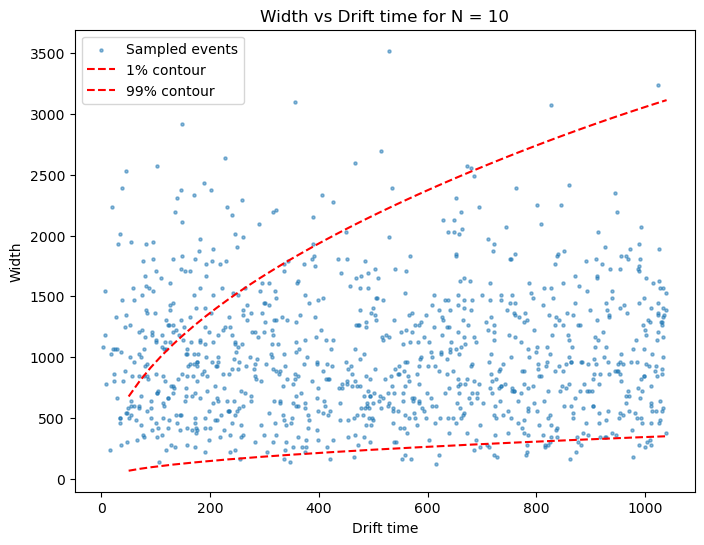

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(events["drift_time"], events["width"], s=5, alpha=0.5, label="Sampled events")
plt.plot(drift_times, lower_contour, 'r--', label="1% contour")
plt.plot(drift_times, upper_contour, 'r--', label="99% contour")
plt.xlabel("Drift time")
plt.ylabel("Width")
plt.title(f"Width vs Drift time for N = {N_fixed}")
plt.legend()
plt.show()
